In [1]:
import os
import cv2
import time
import math
import random
import segyio
import skimage
import numpy as np
import tensorflow as tf
from dotmap import DotMap
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback


import src.plotter
import src.preprocess
import src.data_loader
from src.customCallbacks import TrainMonitor, cosine_schedule
from src.models_mae import MaskedAutoencoder

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    except RuntimeError as e:
        print(e)

2024-03-28 17:29:45.952305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 17:29:45.952341: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 17:29:45.952380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 17:29:45.959740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2024-03-28 17:29:48.080135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6821 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:17:00.0, compute capability: 7.5


In [2]:
args = DotMap()
args.batch_size = 50
args.epochs = 400
args.input_size = 224
args.mask_ratio = 0.75

### Load Data

In [3]:
dataParihaka = segyio.tools.cube('data/parihaka_full.sgy')
dataParihaka  = src.preprocess.normalize_data(dataParihaka)

X_train = dataParihaka[1:600,:, :]
X_val = dataParihaka[600:800,:, :]
X_test= dataParihaka[800:900, :, :]

print(f"Training samples: {X_train.shape}")
print(f"Validation samples: {X_val.shape}")
print(f"Testing samples: {X_test.shape}")

X_train_patches = src.preprocess.reshape_patches_list(src.preprocess.create_patch_2D(X_train, patch_size=args.input_size, 
                                                                                     step=int(args.input_size/2)
                                                                                    )
                                                     )
X_val_patches = src.preprocess.reshape_patches_list(src.preprocess.create_patch_2D(X_val, patch_size=args.input_size, 
                                                                                   step=int(args.input_size/2)
                                                                                  )
                                                   )
X_test_patches = src.preprocess.reshape_patches_list(src.preprocess.create_patch_2D(X_test, patch_size=args.input_size, 
                                                                                    step=int(args.input_size/2)
                                                                                   )
                                                    )

X_train_patches = src.preprocess.standarlization_patches(X_train_patches)
X_val_patches = src.preprocess.standarlization_patches(X_val_patches)    
X_test_patches = src.preprocess.standarlization_patches(X_test_patches)

print(f"Training patches samples: {X_train_patches.shape}")
print(f"Validation patches samples: {X_val_patches.shape}")
print(f"Testing patches samples: {X_test_patches.shape}")


batch_train = X_train_patches.shape[0]
idx = np.random.permutation(batch_train)
X_train_patches = X_train_patches[idx]
X_train_patches = X_train_patches[:(batch_train - (batch_train % args.batch_size)), :,:]


batch_val = X_val_patches.shape[0]
idx = np.random.permutation(batch_val)
X_val_patches = X_val_patches[idx]
X_val_patches = X_val_patches[:(batch_val - (batch_val % args.batch_size)),:,:]

batch_test = X_test_patches.shape[0]
idx = np.random.permutation(batch_test)
X_test_patches = X_test_patches[:(batch_test - (batch_test % args.batch_size)),:,:]
    
print(f"Training samples: {X_train_patches.shape}")
print(f"Validation samples: {X_val_patches.shape}")
print(f"Testing samples: {X_test_patches.shape}")

Training samples: (599, 1126, 1168)
Validation samples: (200, 1126, 1168)
Testing samples: (100, 1126, 1168)
Training patches samples: (48519, 224, 224, 1)
Validation patches samples: (16200, 224, 224, 1)
Testing patches samples: (8100, 224, 224, 1)
Training samples: (48500, 224, 224, 1)
Validation samples: (16200, 224, 224, 1)
Testing samples: (8100, 224, 224, 1)


In [4]:
data_generator = src.data_loader.DataLoader(X_train_patches, args.batch_size)
data_generator_val = src.data_loader.DataLoader(X_val_patches, args.batch_size)
test_data = src.data_loader.DataLoader(X_test_patches, args.batch_size)

def gen_data_generator():
    for i in range(data_generator.__len__()):
        yield data_generator.__getitem__(i)

def gen_data_generator_val():
    for i in range(data_generator_val.__len__()):
        yield data_generator_val.__getitem__(i)

        
data_dataset_train =  tf.data.Dataset.from_generator(gen_data_generator, output_signature=(
        tf.TensorSpec(shape=(None, 
                             X_train_patches[0].shape[0], 
                             X_train_patches[0].shape[1], 
                             X_train_patches[0].shape[2]), dtype=tf.float32)
))  #according to tf.data.Dataset.from_generator documentation we have to specify output_signature        
        
        
data_dataset_val =  tf.data.Dataset.from_generator(gen_data_generator_val, output_signature=(
        tf.TensorSpec(shape=(None, 
                             X_train_patches[0].shape[0],  
                             X_train_patches[0].shape[1],
                             X_train_patches[0].shape[2]), dtype=tf.float32)
))  #according to tf.data.Dataset.from_generator documentation we have to specify output_signature

In [5]:
model = MaskedAutoencoder(img_size=224, patch_size=16, in_chans=1,
                          embed_dim=192, depth=3, num_heads=6,
                          decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
                          mlp_ratio=4., mask_ratio=args.mask_ratio, batch_size=args.batch_size)

Model: "mae_decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, 512)]          0         []                            
                                                                                                  
 layer_normalization_6 (Lay  (None, None, 512)            1024      ['input_2[0][0]']             
 erNormalization)                                                                                 
                                                                                                  
 multi_head_attention_3 (Mu  (None, None, 512)            1050624   ['layer_normalization_6[0][0]'
 ltiHeadAttention)                                                  , 'layer_normalization_6[0][0]
                                                                    ']                  

In [6]:
dt = time.localtime()

strinstante = "%02d-%02d-%04d-%02d-%02d" % (dt.tm_year, dt.tm_mon, dt.tm_mday, dt.tm_hour, dt.tm_min)

out_directory = 'pretrain' + "/checkpoint" + strinstante 

if not os.path.exists(out_directory):
    os.makedirs(out_directory)
    
model_save_name = out_directory + "/checkpoint_test_" + strinstante + ".cpk"

train_callbacks = [TrainMonitor(test_data, epoch_interval=5),
                  tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                   patience=20, 
                                                   mode='min'),
                   LearningRateScheduler(cosine_schedule(base_lr=1e-3, 
                                      total_steps=args.epochs, 
                                      warmup_steps=20)),
                   
                   tf.keras.callbacks.ModelCheckpoint(model_save_name, 
                                               save_best_only=True, 
                                               save_weights_only=True, 
                                               monitor="val_loss", 
                                               verbose=1
                                            ),
                  ]

2024-03-28 17:30:15.292026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-03-28 17:30:15.385806: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-28 17:30:15.389626: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.5
2024-03-28 17:30:15.389666: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-03-28 17:30:15.389786: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-28 1


Idx chosen: 21


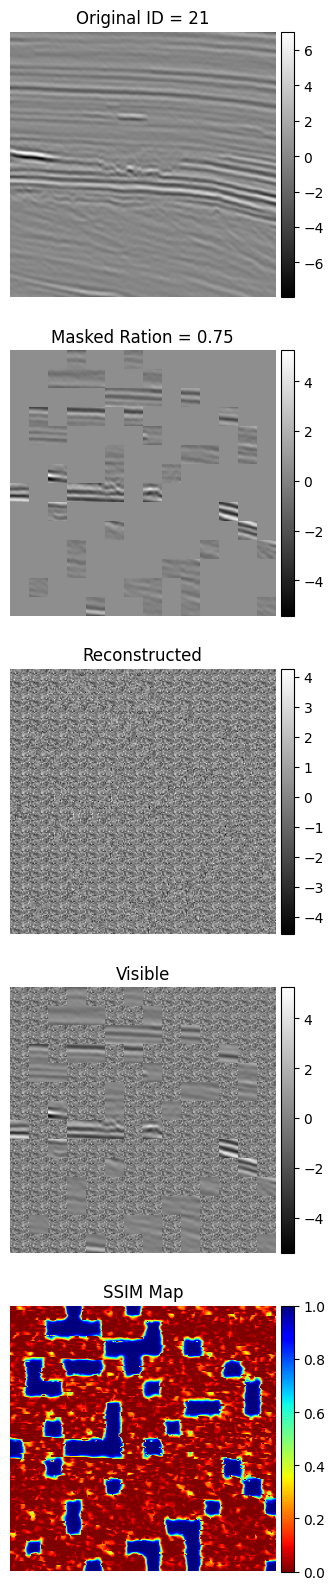

In [7]:
src.plotter.plot_result(next(iter(test_data)),
                    model,
                    model.mask_ratio
                               )

In [8]:
def custom_loss(y_true, y_pred, mask):  
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    loss = tf.math.reduce_sum((loss * mask)) / tf.math.reduce_sum(mask)
    
    return loss

2024-03-28 17:30:17.204409: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-28 17:30:17.204551: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-28 17:30:17.206344: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-28 17:30:17.206567: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before

Epoch 1/400


2024-03-28 17:30:26.465664: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-28 17:30:26.467604: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-28 17:30:26.467927: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-03-28 17:30:26.471394: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-03-28 17:30:26.514166: E tensorflow/compiler/xla/st

      1/Unknown - 16s 16s/step - loss: 2.3149

2024-03-28 17:30:33.615520: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



    970/Unknown - 266s 258ms/step - loss: 0.8013

2024-03-28 17:34:43.852375: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17808142621094255929
2024-03-28 17:35:17.785718: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8555905105014336214



Idx chosen: 2


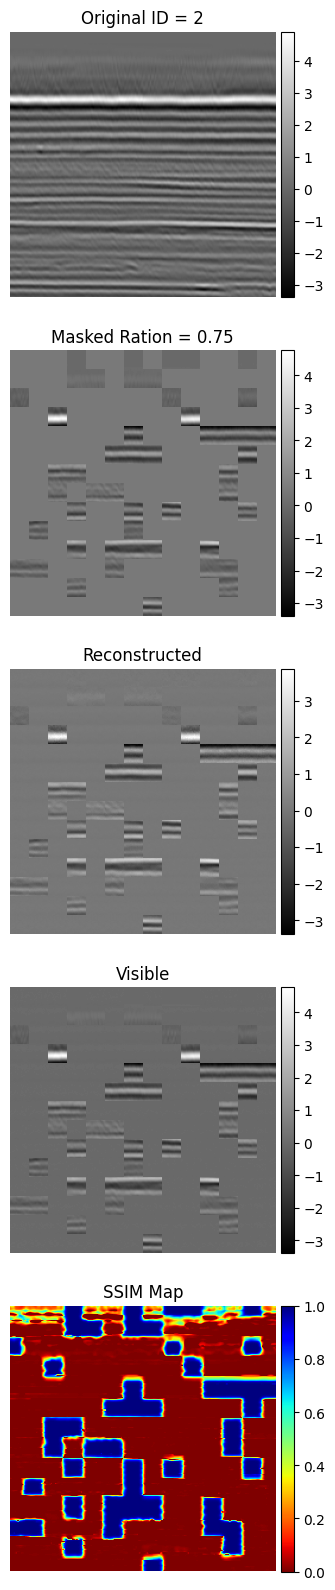


Epoch 1: val_loss improved from inf to 0.75997, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 301s 294ms/step - loss: 0.8013 - val_loss: 0.7600 - lr: 5.0000e-05
Epoch 2/400
970/970 [==============================] - ETA: 0s - loss: 0.7012
Epoch 2: val_loss improved from 0.75997 to 0.54543, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 288s 297ms/step - loss: 0.7012 - val_loss: 0.5454 - lr: 1.0000e-04
Epoch 3/400
970/970 [==============================] - ETA: 0s - loss: 0.4660
Epoch 3: val_loss improved from 0.54543 to 0.41643, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 288s 297ms/step - loss: 0.4660 - val_loss: 0.4164 - lr: 1.5000e-04
Epoch 4/400
970/970 [==============================] - ETA: 0s - loss: 0.4065
Epoc

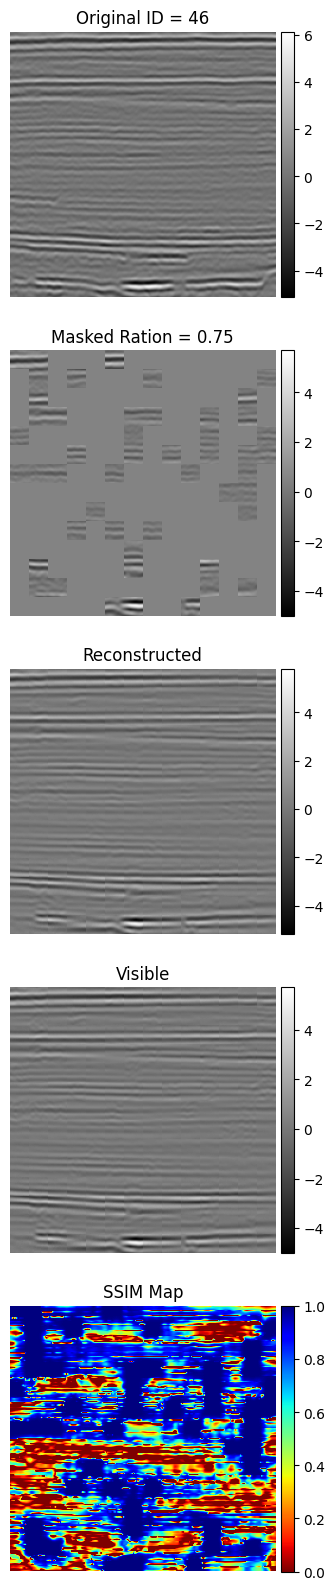


Epoch 6: val_loss improved from 0.35377 to 0.33217, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 289s 298ms/step - loss: 0.3471 - val_loss: 0.3322 - lr: 3.0000e-04
Epoch 7/400
970/970 [==============================] - ETA: 0s - loss: 0.3308
Epoch 7: val_loss improved from 0.33217 to 0.32111, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 289s 298ms/step - loss: 0.3308 - val_loss: 0.3211 - lr: 3.5000e-04
Epoch 8/400
970/970 [==============================] - ETA: 0s - loss: 0.3189
Epoch 8: val_loss improved from 0.32111 to 0.30987, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 289s 298ms/step - loss: 0.3189 - val_loss: 0.3099 - lr: 4.0000e-04
Epoch 9/400
970/970 [==============================] - ETA: 0s - loss: 0.3111


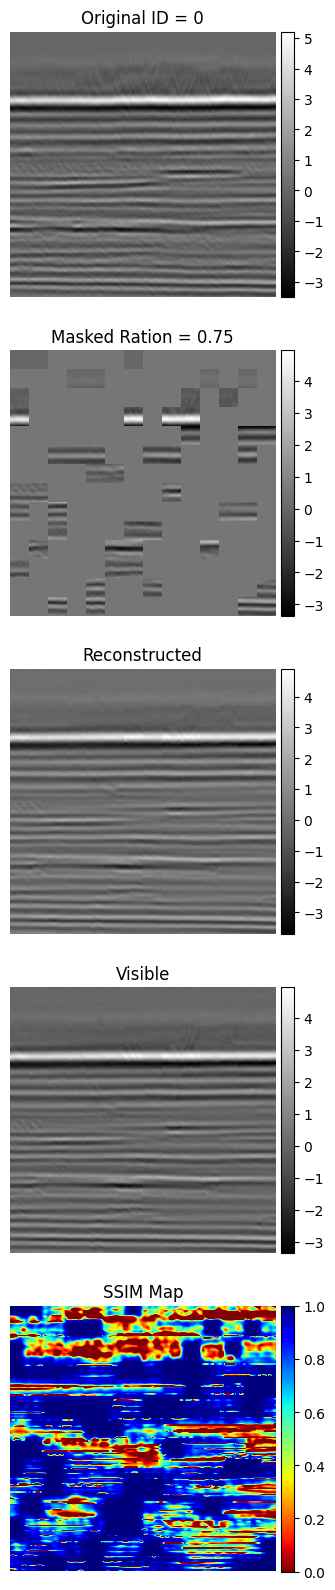


Epoch 11: val_loss improved from 0.30523 to 0.30204, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 289s 298ms/step - loss: 0.2995 - val_loss: 0.3020 - lr: 5.5000e-04
Epoch 12/400
970/970 [==============================] - ETA: 0s - loss: 0.2949
Epoch 12: val_loss improved from 0.30204 to 0.29616, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 289s 298ms/step - loss: 0.2949 - val_loss: 0.2962 - lr: 6.0000e-04
Epoch 13/400
970/970 [==============================] - ETA: 0s - loss: 0.2923
Epoch 13: val_loss improved from 0.29616 to 0.29488, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 289s 298ms/step - loss: 0.2923 - val_loss: 0.2949 - lr: 6.5000e-04
Epoch 14/400
970/970 [==============================] - ETA: 0s - loss: 0

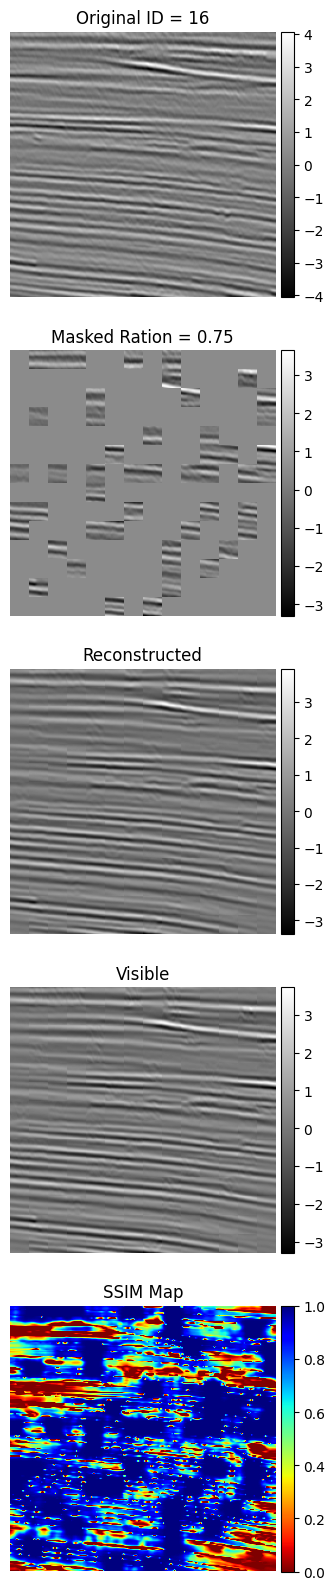


Epoch 16: val_loss improved from 0.29207 to 0.29095, saving model to pretrain/checkpoint2024-03-0028-17-30/checkpoint_test_2024-03-0028-17-30.cpk
970/970 [==============================] - 289s 298ms/step - loss: 0.2828 - val_loss: 0.2910 - lr: 8.0000e-04
Epoch 17/400
733/970 [=====================>........] - ETA: 1:02 - loss: 0.2808

In [ ]:
# Compile and pretrain the model.
model.compile(
    optimizer=tf.keras.optimizers.AdamW(),
    loss_fn=custom_loss
)


history = model.fit(data_dataset_train, 
                    epochs=args.epochs, 
                    shuffle=True, 
                    validation_data=data_dataset_val, 
                    callbacks=train_callbacks,
)

In [ ]:
model = MaskedAutoencoder(img_size=224, patch_size=16, in_chans=1,
                          embed_dim=192, depth=3, num_heads=6,
                          decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
                          mlp_ratio=4., mask_ratio=args.mask_ratio, batch_size=args.batch_size, Lambda=True)

model.built = True
model.load_weights(model_save_name)
model.encoder_block.save_weights(out_directory + '/checkpoint_test_encoder.h5')
model.summary()

In [ ]:
test_images = next(iter(test_data))
x = test_images

plotter.plot_result(test_images,
                    model,
                    model.mask_ratio
                               )